In [2]:
import pandas as pd

df = pd.read_csv('direction_data.csv')
df = df.fillna(9999)
df.head()

,t1,t2,gr1,gr2,s1p1,s1p2,s2p1,s2p2,direction
0,0,0,9999.000000,0.211863,9999.000000,9999.000000,1.379846,1.591709,no-left
1,0,0,9999.000000,0.666555,9999.000000,9999.000000,0.833855,1.500410,no-left
2,0,0,0.205575,0.524583,1.642306,1.847881,0.895598,1.420181,no-left
3,0,0,2.276674,0.295043,0.544720,2.821393,1.083164,1.378206,no-left
4,0,0,2.260734,0.585052,0.684987,2.945721,0.856547,1.441600,no-left


# Mutual Information and ANOVA Test

C:\Users\paulk\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


t1      0.000000e+00
t2      0.000000e+00
s2p1    2.367260e-13
s2p2    2.388697e-13
gr2     2.420297e-13
gr1     5.478490e-07
s1p2    5.544743e-07
s1p1    5.641881e-07
dtype: float64
>1 0.623 (0.030)
>1 0.647 (0.153)
>2 1.000 (0.000)
>2 0.827 (0.128)
>3 0.992 (0.028)
>3 0.872 (0.130)
>4 0.993 (0.025)
>4 0.912 (0.112)
>5 0.990 (0.030)
>5 0.933 (0.118)
>6 0.989 (0.033)
>6 0.961 (0.087)
>7 0.990 (0.030)
>7 0.997 (0.018)
>8 0.990 (0.030)
>8 0.989 (0.033)


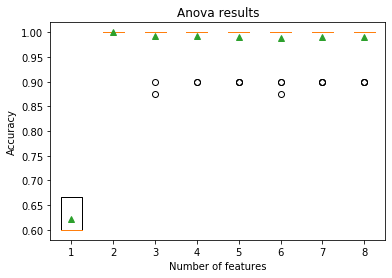

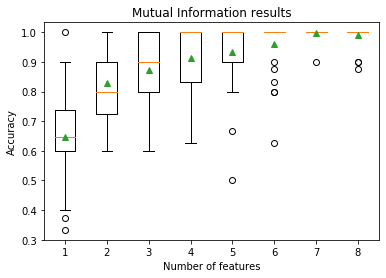

Best features according to mutual information gain
s1p2    0.404306
s1p1    0.637685
gr1     0.653825
s2p2    0.699089
t1      0.699587
s2p1    0.732392
t2      0.750189
gr2     0.832550
dtype: float64


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std

x = df.drop(columns=['direction'])
y = df['direction']
model = DecisionTreeClassifier()

#ANOVA TEST
fscore, pval = f_classif(x,y)
pval = pd.Series(pval)

pval.index = x.columns
print(pval.sort_values(ascending=True))

results_anova = []
results_mi = []
num_features = [i+1 for i in range(x.shape[1])]
for k in range(x.shape[1]):
    fs = SelectKBest(score_func=f_classif, k=k+1)
    pipeline = Pipeline(steps=[('anova', fs), ("lr", model)])
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores_a = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print('>%d %.3f (%.3f)' % (k+1, mean(scores_a), std(scores_a)))
    
    fs = SelectKBest(score_func=mutual_info_classif, k=k+1)
    pipeline = Pipeline(steps=[('mutual_information', fs), ("lr", model)])
    scores_m = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print('>%d %.3f (%.3f)' % (k+1, mean(scores_m), std(scores_m)))
    results_anova.append(scores_a)
    results_mi.append(scores_m)

plt.figure(0)
plt.boxplot(results_anova, labels=num_features, showmeans=True)
plt.title("Anova results")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")

#plt.hold(True)
plt.figure(1)
plt.boxplot(results_mi, labels=num_features, showmeans=True)
plt.title("Mutual Information results")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.show()

#grabbing the best features according to mutual information
#from the plot best median results occurr with 3 features

clf = mutual_info_classif(x,y,random_state=1)
clf = pd.Series(clf)
clf.index = x.columns

print("Best features according to mutual information gain")
print(clf.sort_values(ascending=True))

# GridSearch CV to confirm the results given the best feature set

Mutual information may not be totally worthwhile metric to find the best results, as triggers may show very similar information. However we see form the anova analysis, they are the most statistically significant when it comes to classification accuracy using the two sensor system.

In [27]:
from sklearn.linear_model import LogisticRegression

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LogisticRegression(solver="liblinear")
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('anova', fs), ('lr', model)])

#create the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(x.shape[1])]

#define the grid search
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
results = search.fit(x, y)
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Configuration: %s' % results.best_params_)

Best Mean Accuracy: 1.000
Best Configuration: {'anova__k': 2}


C:\Users\paulk\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\paulk\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\Users\paulk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


grid search confirms the results. Using the trigger features we achieve the best classification results.